# Introduction  

The **CICIDS2017 dataset** is a comprehensive collection of network traffic data, designed for evaluating intrusion detection systems (IDS). This notebook focuses on preparing the dataset for machine learning (ML) models by implementing a thorough data cleaning and treatment pipeline.  

The initial analysis involved exploratory data analysis (EDA) to uncover the dataset's structure and key characteristics. Building on these insights, this notebook ensures the dataset is ready for effective model training and evaluation by addressing issues such as data inconsistencies, feature overlapping, and output preparation.  

### Objectives of This Notebook:
1. **Data Cleaning**:
   - Handle missing values through removal or imputation.  
   - Eliminate duplicates and correct inconsistencies to maintain data quality.  

2. **Exploratory Data Analysis (EDA)**:  
   - Visualize and analyze the dataset to identify patterns, outliers, and correlations.  

3. **Feature Importance Evaluation**:
   - Evaluate feature importance with statistical tests and Random Forest.

4. **Dataset Preparation for Modeling**:  
   - Save a **cleaned dataset** for baseline model training.  

This pipeline ensures the CICIDS2017 dataset is refined for robust ML and Network IDS Engine.

In [2]:
# Importing the relevant libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

from scipy import stats

ModuleNotFoundError: No module named 'numpy'

# Helper Functions

Section to organize some useful functions to further explore and work on the dataset.

In [ ]:
# 1. Get numerical and categorical features (df, target_col='Attack Type') -> numerical features; categorical features
def get_feature_types(df, target_col='Attack Type'):
    """
    Parameters:
    -----------
    df : pandas.DataFrame (Input DataFrame containing the dataset)
    target_col : str, optional (default='Attack Type')

    Returns:
    --------
    tuple : (list, list)
        Two lists containing:
        - numeric_features: List of column names with numerical data
        - categorical_features: List of column names with categorical data

    Notes:
    ------
    - The target column is excluded from both feature lists if present
    """

    numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = df.select_dtypes(include=['object']).columns.tolist()

    # Remove target column if present
    if target_col in numeric_features:
        numeric_features.remove(target_col)
    if target_col in categorical_features:
        categorical_features.remove(target_col)

    return numeric_features, categorical_features

In [ ]:
# 2. Correlation analysis (df, numeric_features) -> list of tuples with highly correlaed features
def correlation_analysis(df, numeric_features, threshold=0.85):
    """
    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset
    numeric_features : list
        List of column names containing numerical features to analyze
    threshold : float
        Threshold for determining highly correlated features (default='0.85')

    Returns:
    --------
    list of tuples
        List of highly correlated feature pairs and their correlation values
        Each tuple contains (feature1, feature2, correlation_value)

    Notes:
    ------
    - Generates a correlation matrix heatmap
    - Identifies feature pairs with absolute correlation > 0.85
    - Only returns upper triangle of correlation matrix to avoid duplicates
    - The heatmap uses a diverging color scheme centered at 0
    """

    # Calculate correlation matrix
    corr_matrix = df[numeric_features].corr()

    # Plot correlation heatmap
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, linewidth = 0.5)
    plt.title('Feature Correlation Heatmap')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

    # Identify highly correlated features
    threshold = threshold
    high_corr = np.where(np.abs(corr_matrix) > threshold)
    high_corr = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                 for x, y in zip(*high_corr) if x != y and x < y]

    return high_corr

In [ ]:
# 3. Variance analysis (df, numeric_features, target_col='Attack Type') – Levene -> dict with results
def analyze_variance_homogeneity(df, numeric_features, target_col='Attack Type'):  
    """  
    Analyze the homogeneity of variances using Levene's test.  

    Parameters:  
    -----------  
    df : pandas.DataFrame  
        Input DataFrame containing the dataset.  
    numeric_features : list  
        List of column names containing numerical features to analyze. 
    target_col : str, optional (default='Attack Type')
        Name of the target column

    Returns:  
    --------  
    dict  
        Dictionary containing the results of Levene's test for each feature.  
    """  
    
    results_levene = {}  
    
    for feature in numeric_features:  
        # Group data by y and filter out groups with zero values  
        groups = [group[feature].dropna().values for name, group in df.groupby(target_col)   
                    if not group[feature].dropna().empty]  
        
        # Filter out groups that contain only zero values or have zero variance  
        groups = [group for group in groups if len(group) > 0 and np.any(group != 0) and np.var(group) > 0]  
        
        # Check if there are at least two groups with valid data  
        if len(groups) < 2:  
            print(f"Not enough valid groups to perform Levene's test for feature: {feature}")  
            continue  # Skip this feature if not enough valid groups  

        # Perform Levene's Test  
        stat_levene, p_value_levene = stats.levene(*groups)  
        results_levene[feature] = {'Statistic': stat_levene, 'p-value': p_value_levene}  

    return results_levene

In [ ]:
# 4. Feature importance analysis (df, numeric_features, target_col='Attack Type') – Kruskal-Wallis -> df with H-statistics and p-values
def analyze_feature_importance(df, numeric_features, target_col='Attack Type'):
    """  
    Analyze feature importance using the Kruskal-Wallis test.  

    Parameters:  
    -----------  
    df : pandas.DataFrame  
        Input DataFrame containing the dataset  
    numeric_features : list  
        List of column names containing numerical features to analyze  
    target_col : str, optional (default='Attack Type')
        Name of the target column

    Returns:  
    --------  
    pandas.DataFrame  
        DataFrame containing H-statistics and p-values for each feature,  
        sorted by H-statistic in descending order  

    Notes:  
    ------  
    - Uses the Kruskal-Wallis test to assess feature importance  
    - Higher H-statistic indicates stronger relationship with target variable  
    - Generates bar plot of H-statistics for visual comparison  
    - Features are sorted by importance in the visualization  
    """

    h_scores = {}  
    
    for feature in numeric_features:  
        # Group data by y and perform the Kruskal-Wallis test  
        groups = [group[feature].dropna().values for name, group in df.groupby(target_col)]  
        h_stat, p_val = stats.kruskal(*groups)  
        h_scores[feature] = {'H-statistic': h_stat, 'p-value': p_val}  

    # Create a DataFrame from the results  
    h_scores_df = pd.DataFrame.from_dict(h_scores, orient='index')  
    h_scores_df = h_scores_df.sort_values('H-statistic', ascending=False)  

    # Plotting H-statistics  
    plt.figure(figsize=(18, 10))  
    plt.bar(range(len(h_scores_df)), h_scores_df['H-statistic'], color='skyblue')  
    plt.xticks(range(len(h_scores_df)), h_scores_df.index, rotation=90)  
    plt.title('Feature Importance based on H-statistic (Kruskal-Wallis Test)')  
    plt.xlabel('Features')  
    plt.ylabel('H-statistic')  
    plt.tight_layout()  
    plt.show()  

    return h_scores_df

In [6]:
# 5. Feature importance analysis(df, numeric_features, target_col='Attack Type') – Tree Model -> df with features ordered by importance; confusion matrix; labels; cv_scores
def analyze_feature_importance_rf(df, numeric_features, target_col='Attack Type'):
    """
    Analyze feature importance using a Random Forest classifier.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset
    numeric_features : list
        List of column names containing numerical features to analyze
    target_col : str
        Column name of the target variable

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing feature importances sorted by importance in descending order
    cm
        Confusion Matrix for further analysis
    rf_labels
        Labels for plotting the confusion matrix
    cv_scores
        Cross-validation scores for future reference

    Notes:
    ------
    - Uses a Random Forest classifier to assess feature importance.
    - Generates bar plot of feature importances for visual comparison.
    """

    # Hyperparameter settings
    hyperparameters = {
        'n_estimators': 150,    # Number of trees
        'max_depth': 30,        # Limit tree depth
        'random_state': 42,     # For reproducibility
        'n_jobs': -1            # Use all available cores
    }

    # Prepare the data
    X = df[numeric_features]
    y = df[target_col]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=hyperparameters['random_state'], stratify=y)

    # Create the Random Forest model with specified hyperparameters
    rf = RandomForestClassifier(**hyperparameters)

    # Fit the model on the training set
    rf.fit(X_train, y_train)

    # Cross-validation on the training set
    cv_scores = cross_val_score(rf, X_train, y_train, cv=5, n_jobs=-1)
    print(f'Cross-Validation Score: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}')
    
    # Predict on test set
    y_pred = rf.predict(X_test)

    # Feature importances
    importances = rf.feature_importances_
    feature_importance_df = pd.DataFrame({'Feature': numeric_features, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

    # Confusion matrix
    rf_labels = rf.classes_
    cm = confusion_matrix(y_test, y_pred)

    # Calculate test scores
    report = classification_report(y_test, y_pred, target_names=rf_labels)
    print("\nClassification Report:\n")
    print(report, end='\n\n')

    # Plot feature importances
    plt.figure(figsize=(18, 12))
    plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.ylabel('Importance')
    plt.xlabel('Features')
    plt.title('Feature Importance from Random Forest')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return feature_importance_df, cm, rf_labels, cv_scores

In [7]:
# 6. Calculation of the percentage of outliers for each feature (df) – IQR -> dict with outliers percentage
def calculate_outliers_percentage(df):
    """
    Calculate the percentage of outliers for each feature in the DataFrame using the IQR method.

    Parameters:
    -----------
    df : pandas.DataFrame
        Input DataFrame containing the dataset.

    Returns:
    --------
    dict
        Dictionary containing the percentage of outliers for each feature.

    Notes:
    ------
    - Uses the Interquartile Range (IQR) method to identify outliers.
    - Outliers are defined as values below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR.
    - The function returns a dictionary with feature names as keys and outlier percentages as values.
    """

    outlier_percentages = {}  # empty dictionary to store outlier percentages

    for column in df.columns:
        Q1 = df[column].quantile(0.25)  # first quartile (Q1) for the column
        Q3 = df[column].quantile(0.75)  # third quartile (Q3) for the column
        IQR = Q3 - Q1  # Interquartile Range (IQR)

        lower_bound = Q1 - 1.5 * IQR  # lower bound for outliers
        upper_bound = Q3 + 1.5 * IQR  # upper bound for outliers

        # Identify outliers in the column
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

        # Calculate the percentage of outliers for the column
        outlier_percentage = len(outliers) / len(df) * 100

        # Store the outlier percentage in the dictionary
        outlier_percentages[column] = outlier_percentage

    return outlier_percentages


# 1. Initial Exploration

The first step is to load the dataset and examine its basic properties, such as dimensions, data types, and missing values.

## 1.1. Loading the Dataset

In [1]:
# List to store DataFrames
dfs = []

# Load the datasets
for dirname, _, filenames in os.walk('/Data/MachineLearningCVE'):
    for filename in filenames:
        dfs.append(pd.read_csv(os.path.join(dirname, filename)))

NameError: name 'os' is not defined

In [9]:
# Data dimensions of each individual dataset
for i, data in enumerate(dfs, start=1):
    rows, cols = data.shape
    print(f'df{i} -> {rows} rows, {cols} columns')

df1 -> 286467 rows, 79 columns
df2 -> 170366 rows, 79 columns
df3 -> 445909 rows, 79 columns
df4 -> 225745 rows, 79 columns
df5 -> 529918 rows, 79 columns
df6 -> 191033 rows, 79 columns
df7 -> 288602 rows, 79 columns
df8 -> 692703 rows, 79 columns


## 1.2. Merging the DataFrames

As noted by Panigrahi and Borah (2018), a typical IDS should be able to handle different types of attacks. Since the CICIDS2017 dataset is divided into eight files containing various attack data, these files should be merged into a single cohesive unit.

In [10]:
# Concatenate all DataFrames into a single DataFrame
data = pd.concat(dfs, axis=0, ignore_index=True)

# Deleting DataFrames after merging
for df in dfs: del df

## 1.3. Data Overview

In [11]:
# Display the first few rows
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,22,1266342,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,22,1319353,41,44,2664,6954,456,0,64.975610,109.864573,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,22,160,1,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,22,1303488,41,42,2728,6634,456,0,66.536585,110.129945,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,35396,77,1,2,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [12]:
# Display 10 random rows
data.sample(n=10, random_state=42)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
746827,443,20829,1,1,0,0,0,0,0.000000,0.000000,...,20,0.000000,0.000000,0,0,0.0,0.00000,0,0,BENIGN
946912,80,1413228,3,5,26,11601,20,0,8.666667,10.263203,...,20,0.000000,0.000000,0,0,0.0,0.00000,0,0,DDoS
2216843,80,99951883,9,7,317,11595,317,0,35.222222,105.666667,...,32,999.000000,0.000000,999,999,99900000.0,0.00000,99900000,99900000,DoS Hulk
699389,80,12984169,9,11,10081,3626,3445,0,1120.111111,1452.563720,...,20,0.000000,0.000000,0,0,0.0,0.00000,0,0,BENIGN
1170268,80,116017190,16,14,520,802,436,0,32.500000,107.610408,...,20,30442.181818,22653.805702,98745,23484,9998871.0,16434.76758,10012179,9950666,BENIGN
800686,53,226,2,2,46,46,23,23,23.000000,0.000000,...,32,0.000000,0.000000,0,0,0.0,0.00000,0,0,BENIGN
1434488,53,63936,1,1,49,161,49,49,49.000000,0.000000,...,32,0.000000,0.000000,0,0,0.0,0.00000,0,0,BENIGN
1968368,443,63405,5,4,121,3110,121,0,24.200000,54.112845,...,32,0.000000,0.000000,0,0,0.0,0.00000,0,0,BENIGN
934343,443,6310806,54,94,2958,170879,517,0,54.777778,142.380260,...,32,0.000000,0.000000,0,0,0.0,0.00000,0,0,BENIGN
693547,53,193,2,2,68,100,34,34,34.000000,0.000000,...,32,0.000000,0.000000,0,0,0.0,0.00000,0,0,BENIGN


In [13]:
# Get dataset dimensions
print(f"Dataset Dimensions: {data.shape}")

Dataset Dimensions: (2830743, 79)


In [14]:
# Display data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

By checking the data types, it is safe to assume the dataset countains only metric features, considering 'Label' as 'y' (the only categorical column).

In [15]:
# Checking for missing values
missing_values = data.isna().sum()
missing_percentage = (missing_values / len(data)) * 100

# Printing columns with missing values
for column, count in missing_values.items():
    if count != 0:
        print(f"Column '{column}' has {count} missing values, which is {missing_percentage[column]:.2f}% of the total")

Column 'Flow Bytes/s' has 1358 missing values, which is 0.05% of the total


The number of missing values may initially seem irrelevant; however, we can decide on the approach after further analysis.

# 2. Data Cleaning

In [16]:
# Removal of leading/trailing whitespace
col_names = {col: col.strip() for col in data.columns}
data.rename(columns = col_names, inplace = True)

## 2.1. Duplicates and Infinite

In [17]:
# Checking and counting duplicates
duplicates = data.duplicated()
duplicate_count = duplicates.sum()

# Output results
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 308381


Removing duplicates from a dataset is often considered safe and beneficial as it enhances data integrity, improves statistical accuracy, increases efficiency, and simplifies analysis.

In [18]:
# Removal of duplicates
data = data.drop_duplicates(keep='first')
del duplicates
data.shape

(2522362, 79)

The same can be done for columns

In [19]:
# Identify columns with identical data
identical_columns = {}
columns = data.columns
list_control = columns.copy().tolist()

# Compare each pair of columns
for col1 in columns:
    for col2 in columns:
        if col1 != col2:
            if data[col1].equals(data[col2]):
                if (col1 not in identical_columns) and (col1 in list_control):
                    identical_columns[col1] = [col2]
                    list_control.remove(col2)
                elif (col1 in identical_columns) and (col1 in list_control):
                    identical_columns[col1].append(col2)
                    list_control.remove(col2)

# Print the result
if identical_columns:
    print("Identical columns found:")
    for key, value in identical_columns.items():
        print(f"'{key}' is identical to {value}")
else: print("No identical columns found.")

Identical columns found:
'Total Fwd Packets' is identical to ['Subflow Fwd Packets']
'Total Backward Packets' is identical to ['Subflow Bwd Packets']
'Fwd PSH Flags' is identical to ['SYN Flag Count']
'Bwd PSH Flags' is identical to ['Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
'Fwd URG Flags' is identical to ['CWE Flag Count']
'Fwd Header Length' is identical to ['Fwd Header Length.1']


In [20]:
# Removing the columns with duplicated values
for key, value in identical_columns.items():
    data.drop(columns=value, inplace=True)

In [21]:
print(data.columns)
data.shape

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Fwd Header Length', 'Bwd Header Length',
       'Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length',
       'Max Packet Length', 'Packet Length Mean', 'Packet Length Std',
       'Packet Length Variance', 'FIN Flag Count', 'RST Flag Count',
       'PSH Flag C

(2522362, 67)

In [22]:
# Checking for infinite values
num_columns = data.select_dtypes(include = np.number).columns
has_infinite = np.isinf(data[num_columns]).sum()
print(has_infinite[has_infinite > 0])

Flow Bytes/s      1211
Flow Packets/s    1564
dtype: int64


Removing infinite values is typically safe and beneficial, as it enhances data integrity, ensures statistical accuracy, aids in proper model training, and clarifies insights.

In [23]:
# Treating infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)

## 2.1. Missing Values

There are different approaches to dealing with missing values. The first step in identifying how to proceed is to understand their impact on the dataset. Here, we will do that by analyzing the y column (Label).

In [24]:
# Attack counts
attack_counts = data['Label'].value_counts().reset_index()
attack_counts.columns = ['Attack Type', 'Number of Occurrences']

# Duplicating the df and dropping rows with missing values
data_no_na = data.dropna()

# Counting the total number of occurrences of each attack after dropping
occurrences_nonull = data_no_na['Label'].value_counts().reset_index()
occurrences_nonull.columns = ['Attack Type', 'Occurrences w/o Null Rows']

# Merging the DataFrames
attack_counts = attack_counts.merge(occurrences_nonull, on='Attack Type', how='left')

# Calculating the difference
attack_counts['Abs Difference'] = attack_counts['Number of Occurrences'] - attack_counts['Occurrences w/o Null Rows']
attack_counts['Difference %'] = ((attack_counts['Abs Difference'] * 100) / attack_counts['Number of Occurrences']).round(2)

# Visualization
attack_counts

,Attack Type,Number of Occurrences,Occurrences w/o Null Rows,Abs Difference,Difference %
0,BENIGN,2096484,2095057,1427,0.07
1,DoS Hulk,172849,172846,3,0.00
2,DDoS,128016,128014,2,0.00
3,PortScan,90819,90694,125,0.14
4,DoS GoldenEye,10286,10286,0,0.00
5,FTP-Patator,5933,5931,2,0.03
6,DoS slowloris,5385,5385,0,0.00
7,DoS Slowhttptest,5228,5228,0,0.00
8,SSH-Patator,3219,3219,0,0.00
9,Bot,1953,1948,5,0.26


In [25]:
# Cleaning up
del data_no_na

# Evaluating percentage of missing values per column
threshold = 10
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Filter columns with missing values over the threshold
high_missing_cols = missing_percentage[missing_percentage > threshold]

# Print columns with high missing percentages
if len(high_missing_cols) > 0:
    print(f'The following columns have over {threshold}% of missing values:')
    print(high_missing_cols)
else:
    print('There are no columns with missing values greater than the threshold')

There are no columns with missing values greater than the threshold


The analysis of missing values across the dataset suggests that missing values are not heavily concentrated in any single column and that the dataset can tolerate row-wise removal without significant impact.

In [26]:
row_missing_percentage = (data.isna().sum(axis=1) / data.shape[1]) * 100
print(row_missing_percentage.describe())

missing_rows = data.isna().any(axis=1).sum()
print(f'\nTotal rows with missing values: {missing_rows}')

count    2.522362e+06
mean     1.850907e-03
std      7.430795e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.985075e+00
dtype: float64

Total rows with missing values: 1564


Following previous studies, such as Panigrahi and Borah (2018), and considering the minimal impact of removing rows with missing values (concentrated on the Benign class), we will proceed to drop these rows from the DataFrame.

In [27]:
# Dropping missing values
data = data.dropna()
print(f'Dataset shape after row-wise removal: {data.shape}')

Dataset shape after row-wise removal: (2520798, 67)


## 2.2. Data-Driven Feature Selection

The idea here is to perform a straightforward manual feature selection process that focuses on examining the dataset critically.

In [28]:
# Check for numeric columns that contain only a single unique value, indicating no diversity in values.
# Such columns contribute no useful information to the analysis and may be candidates for removal.
only_unique_cols = []
for col in data.columns:
    if len(data[col].unique()) == 1:
        only_unique_cols.append(col)
        print(col)

print(f'\nThe number of columns with only one unique values is: {len(only_unique_cols)}')

Bwd PSH Flags

The number of columns with only one unique values is: 1


Columns with only a single unique value can typically be removed from the dataset before training machine learning models without risk of loss of relevant information.

In [29]:
# Dropping the columns with only one unique value
data.drop(only_unique_cols, axis=1, inplace=True)
del only_unique_cols

In [30]:
# Checking the new shape after cleaning
data.shape

(2520798, 66)

## 2.3. Grouping/ Removing Attack Types

As seen previously, the dataset categorizes various types of attacks into distinct groups, including different variations of Denial of Service (DoS) attacks. Given the imbalance present in the dataset, consolidating these classes could enhance the training process of ML models. This approach allows models to learn from a more balanced representation of the data, potentially improving classification accuracy and model performance.

### 2.3.1. Grouping attack types

The table below illustrates the proposed grouping of attack categories. For now, DoS and DDoS will remain separate due to their distinct characteristics, such as differences in attack methodology and mitigation strategies, which could impact the model's performance and interpretation.


| **Group**                     | **Attack Type**             | **Count**  |  
|-------------------------------|-----------------------------|------------|  
| **Normal Traffic**            | BENIGN                      | 2,095,057  |  
|                               |                             | **Total: 2,095,057** |  
| **DoS Attacks**              | DoS Hulk                   | 172,846    |  
|                               | DoS GoldenEye               | 10,286     |  
|                               | DoS Slowloris               | 5,385      |  
|                               | DoS Slowhttptest            | 5,228      |
|                               |                             | **Total: 193,745** |
| **DDoS Attacks**              | DDoS                        | 128,014     |
|                               |                             | **Total: 128,014** |
| **Port Scanning**            | PortScan                    | 90,694     |  
|                               |                             | **Total: 90,694**  |  
| **Brute Force Attacks**      | FTP-Patator                 | 5,931      |  
|                               | SSH-Patator                 | 3,219      |  
|                               |                             | **Total: 9,150**   |  
| **Bots**                      | Bot                         | 1,948      |  
|                               |                             | **Total: 1,948**   |  
| **Web Attacks**              | Web Attack – Brute Force    | 1,470      |  
|                               | Web Attack – XSS            | 652        |  
|                               | Web Attack – SQL Injection   | 21         |  
|                               |                             | **Total: 2,143**   |  
| **Infiltration Attacks**     | Infiltration                | 36         |  
|                               |                             | **Total: 36**      |  
| **Miscellaneous**            | Heartbleed                  | 11         |  
|                               |                             | **Total: 11**      |

In [31]:
# Mapping the attacks to the new group
group_mapping = {
    'BENIGN': 'Normal Traffic',
    'DoS Hulk': 'DoS',
    'DDoS': 'DDoS',
    'PortScan': 'Port Scanning',
    'DoS GoldenEye': 'DoS',
    'FTP-Patator': 'Brute Force',
    'DoS slowloris': 'DoS',
    'DoS Slowhttptest': 'DoS',
    'SSH-Patator': 'Brute Force',
    'Bot': 'Bots',
    'Web Attack � Brute Force': 'Web Attacks',
    'Web Attack � XSS': 'Web Attacks',
    'Infiltration': 'Infiltration',
    'Web Attack � Sql Injection': 'Web Attacks',
    'Heartbleed': 'Miscellaneous'
}

# Map to new group column
data['Attack Type'] = data['Label'].map(group_mapping)

In [32]:
# Checking the new values
data['Attack Type'].value_counts()

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Infiltration           36
Miscellaneous          11
Name: count, dtype: int64

In [33]:
# Dropping the old 'Label' column
data.drop(columns='Label', inplace=True)

### 2.3.2. Removal of Attack Types

Given the very low instance counts for 'Infiltration' (36) and 'Heartbleed' (11), it is advisable to remove these categories from the dataset as they can lead to overfitting and unreliable model performance, even techniques like SMOTE may not be sufficient to create a representative training sample.

In [34]:
# Removing rows with statistically irrelevant attack types
data.drop(data[(data['Attack Type'] == 'Infiltration') | (data['Attack Type'] == 'Miscellaneous')].index, inplace=True)

In [35]:
# Data shape and attack counts after removal
print(data.shape)
data['Attack Type'].value_counts()

(2520751, 66)


Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

# 3. Exploratory Data Analysis (EDA)

## 3.1. Descriptive Statistics

In [36]:
data.sample(10)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Attack Type
1551142,62283,53121,2,1,0,0,0,0,0.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic
1405688,443,1668662,6,3,611,162,517,0,101.833333,204.305082,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic
640971,80,1978,2,0,0,0,0,0,0.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic
540921,53,71990,2,2,56,172,28,28,28.000000,0.000000,...,32,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic
563303,53849,999853,2,0,0,0,0,0,0.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic
1033540,80,36013,6,0,36,0,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDoS
2303872,80,98250786,6,6,397,11595,379,0,66.166667,153.284594,...,20,15896.0,0.0,15896,15896,98200000.0,0.0,98200000,98200000,DoS
1750862,53,15194583,4,4,152,530,46,30,38.000000,9.237604,...,20,49027.0,0.0,49027,49027,15100000.0,0.0,15100000,15100000,Normal Traffic
1144830,53,48978,1,1,49,91,49,49,49.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Normal Traffic
956600,80,266536,3,5,26,11607,20,0,8.666667,10.263203,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDoS


In [37]:
data.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,...,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06,2.520751e+06
mean,8.690744e+03,1.659032e+07,1.025880e+01,1.155289e+01,6.065243e+02,1.811292e+04,2.311993e+02,1.920377e+01,6.350189e+01,7.732029e+01,...,5.997266e+00,-3.082291e+03,9.152230e+04,4.616835e+04,1.719410e+05,6.542438e+04,9.337159e+06,5.656738e+05,9.763454e+06,8.892545e+06
std,1.901294e+04,3.523140e+07,7.943824e+02,1.056905e+03,1.011595e+04,2.398149e+06,7.563122e+02,6.079887e+01,1.955512e+02,2.968824e+02,...,6.743909e+02,1.149769e+06,6.858746e+05,4.161453e+05,1.084664e+06,6.106447e+05,2.484810e+07,4.873871e+06,2.561725e+07,2.458139e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,2.080000e+02,2.000000e+00,1.000000e+00,1.200000e+01,6.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,5.062000e+04,2.000000e+00,2.000000e+00,6.600000e+01,1.560000e+02,4.000000e+01,2.000000e+00,3.625000e+01,0.000000e+00,...,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,5.332968e+06,6.000000e+00,5.000000e+00,3.320000e+02,9.970000e+02,2.020000e+02,3.700000e+01,5.200000e+01,7.419280e+01,...,3.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


## 3.2. Correlation Analysis

The correlation analysis provides valuable insights that could inform further data engineering efforts, such as considering the application of Principal Component Analysis (PCA) to reduce dimensionality and enhance model performance.

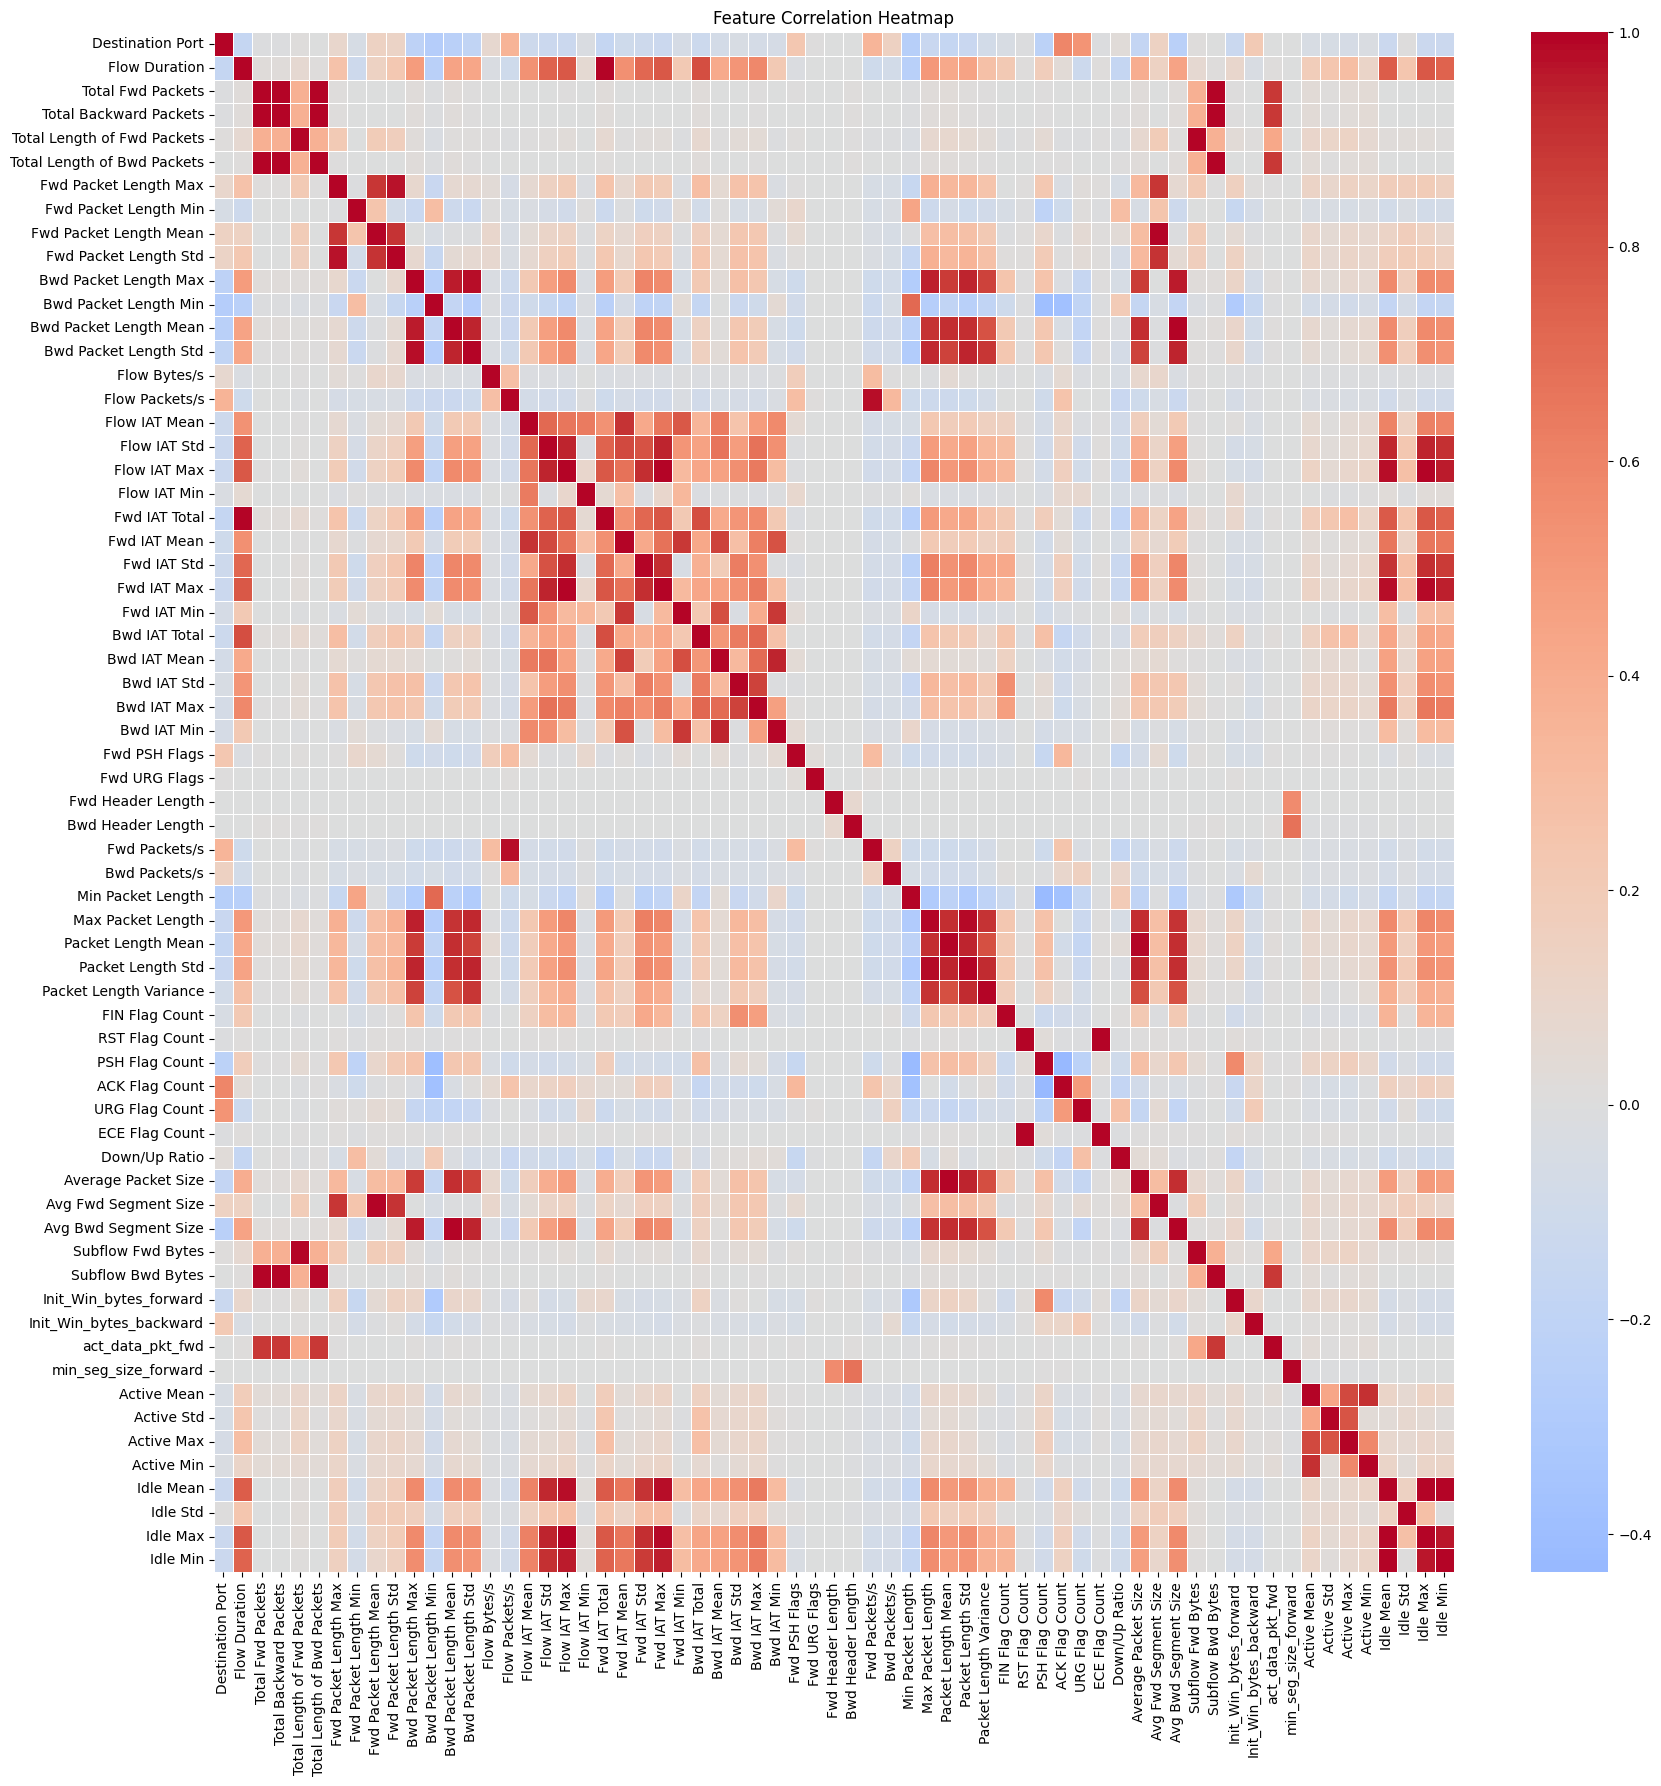

In [38]:
# Correlation Analysis:
numeric_features, categorical_features = get_feature_types(data)
high_corr = correlation_analysis(data, numeric_features)

In [39]:
# Printing the pairs with high correlation and isolating the near/perfect multicollinearity
high_multicollinearity = []
for item in high_corr:
    print(f'{item[0]} has a high correlation with {item[1]}: {item[2].round(4)}')
    if item[2] >= 0.95:
        high_multicollinearity.append(item)

Flow Duration has a high correlation with Fwd IAT Total: 0.9985
Total Fwd Packets has a high correlation with Total Backward Packets: 0.9991
Total Fwd Packets has a high correlation with Total Length of Bwd Packets: 0.997
Total Fwd Packets has a high correlation with Subflow Bwd Bytes: 0.997
Total Fwd Packets has a high correlation with act_data_pkt_fwd: 0.8874
Total Backward Packets has a high correlation with Total Length of Bwd Packets: 0.9945
Total Backward Packets has a high correlation with Subflow Bwd Bytes: 0.9944
Total Backward Packets has a high correlation with act_data_pkt_fwd: 0.8826
Total Length of Fwd Packets has a high correlation with Subflow Fwd Bytes: 1.0
Total Length of Bwd Packets has a high correlation with Subflow Bwd Bytes: 1.0
Total Length of Bwd Packets has a high correlation with act_data_pkt_fwd: 0.884
Fwd Packet Length Max has a high correlation with Fwd Packet Length Mean: 0.889
Fwd Packet Length Max has a high correlation with Fwd Packet Length Std: 0.968

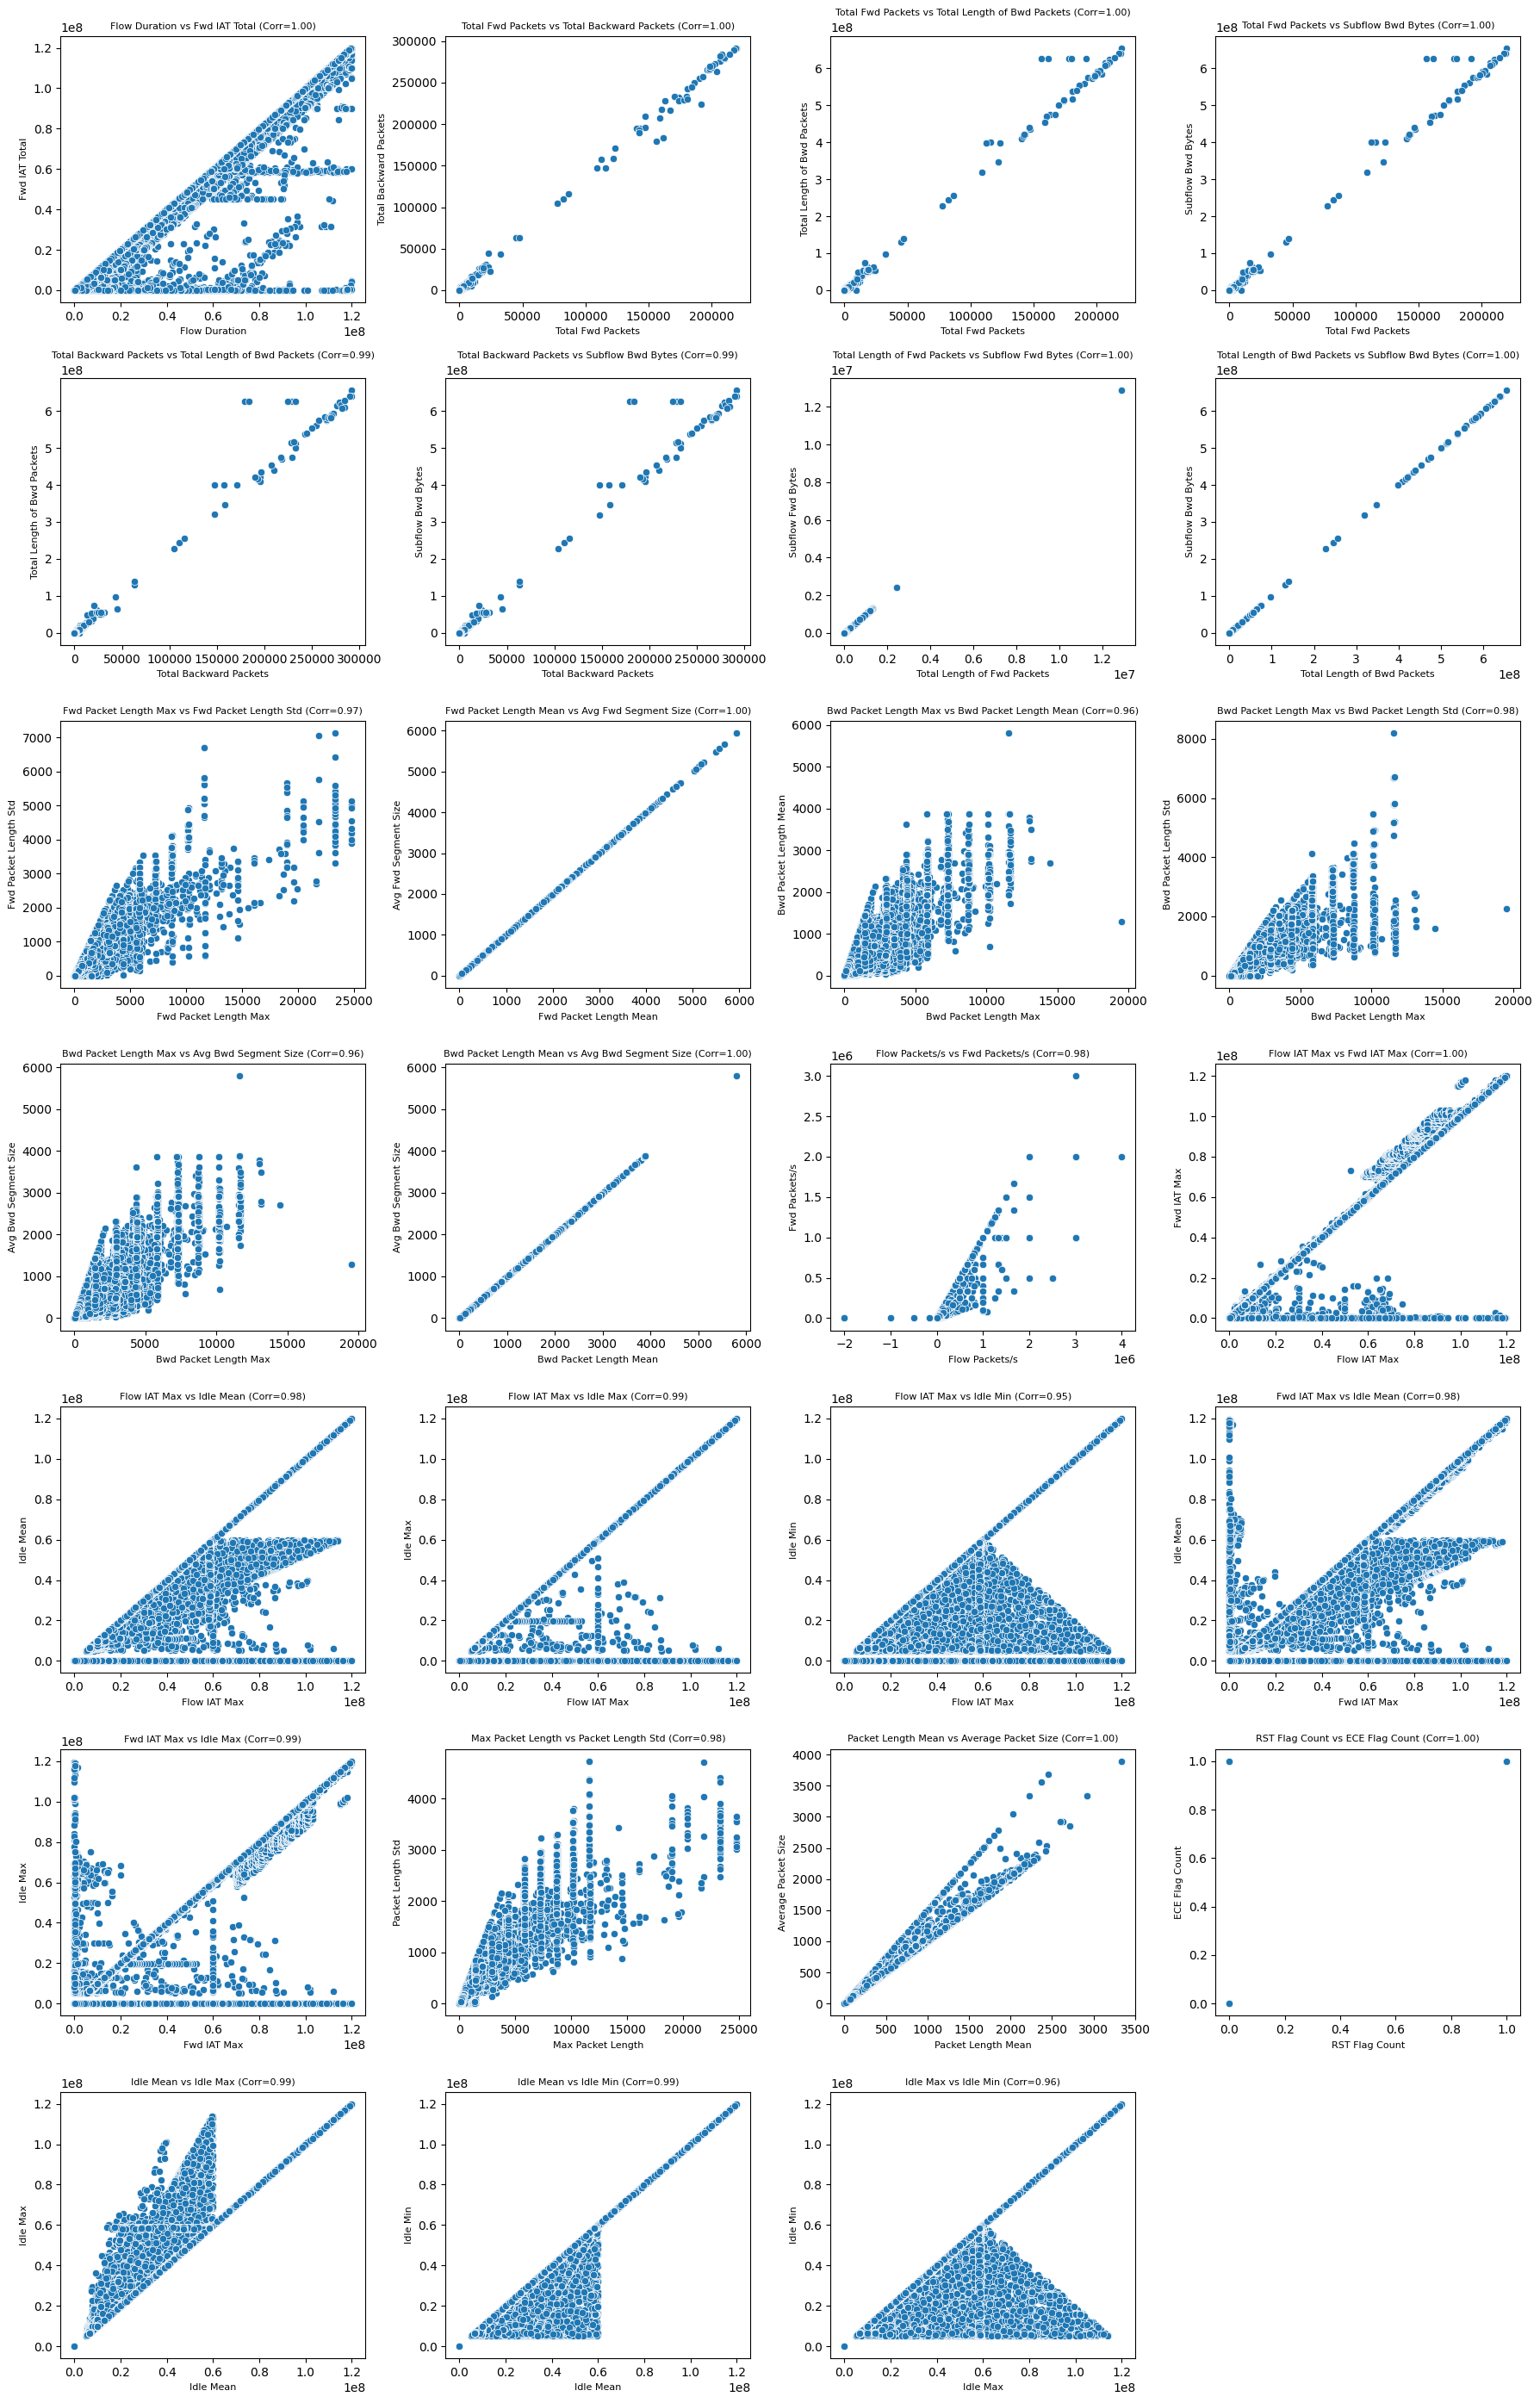

In [40]:
# Plotting the pairs with very high correlation for better visualization

n_plots = len(high_multicollinearity)
n_cols = 4
n_rows = (n_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
axes = axes.flatten()

for i, item in enumerate(high_multicollinearity):
    feature_x = item[0]
    feature_y = item[1]
    corr_value = item[2]

    # Scatter plot
    sns.scatterplot(x=data[feature_x], y=data[feature_y], ax=axes[i])
    axes[i].set_title(f'{feature_x} vs {feature_y} (Corr={corr_value:.2f})', fontsize=8)
    axes[i].set_xlabel(feature_x, fontsize=8)
    axes[i].set_ylabel(feature_y, fontsize=8)

# Hide any unused subplots
for j in range(len(high_multicollinearity), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

By evaluating the plots, we can identify some features with perfect/near-perfect linear correlation. Removing one instance can reduce redundancy and mitigate potential issues with multicollinearity in future models

In [41]:
# Removal of columns based on correlation analysis
selected_columns = ['Total Backward Packets', 'Total Length of Bwd Packets', 'Subflow Bwd Bytes', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size']

# dropping columns with perfect/near perfect multicollinearity
data.drop(columns=selected_columns, inplace=True)

In [42]:
# Updating the variables and checking dataset shape
numeric_features, categorical_features = get_feature_types(data)
data.shape

(2520751, 61)

## 3.3. Outliers

Outlier detection plays a crucial role in ensuring the quality and reliability of a dataset. Identifying features with significant deviations from the norm can help improve model accuracy by preventing skewed results.

<Figure size 1500x1000 with 0 Axes>

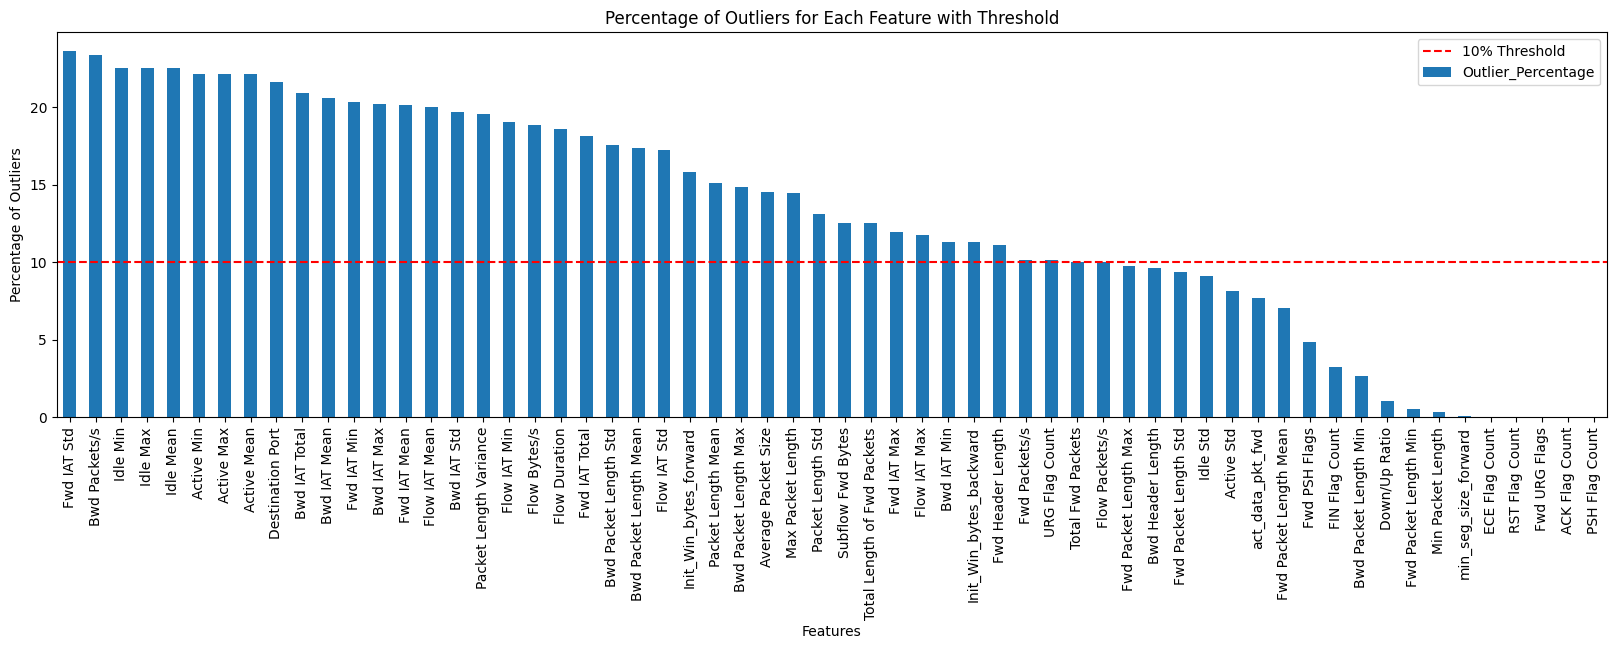

In [43]:
# Calculate outliers percentage
outlier_percentages = calculate_outliers_percentage(data[numeric_features])

# Convert to DataFrame for easier manipulation
outliers_df = pd.DataFrame.from_dict(outlier_percentages, orient='index', columns=['Outlier_Percentage'])

# Define the threshold for concern
threshold = 10

# Identify features with high percentage of outliers
high_outlier_features = outliers_df[outliers_df['Outlier_Percentage'] > threshold]

# Plot the outlier percentages and highlight features above the threshold
plt.figure(figsize=(15, 10))
outliers_df.sort_values(by='Outlier_Percentage', ascending=False).plot(kind='bar', legend=False, figsize=(20, 5))
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold}% Threshold')
plt.xlabel('Features')
plt.ylabel('Percentage of Outliers')
plt.title('Percentage of Outliers for Each Feature with Threshold')
plt.legend()
plt.show()

In [44]:
# Print the features with high outlier percentages
print(f"Features with outlier percentage above {threshold}%:\n")
print(high_outlier_features.sort_values('Outlier_Percentage', ascending=False))

# Cleaning up
del outliers_df

Features with outlier percentage above 10%:

                             Outlier_Percentage
Fwd IAT Std                           23.657989
Bwd Packets/s                         23.402391
Idle Min                              22.501508
Idle Max                              22.501508
Idle Mean                             22.501508
Active Min                            22.167917
Active Max                            22.167917
Active Mean                           22.167917
Destination Port                      21.645137
Bwd IAT Total                         20.926819
Bwd IAT Mean                          20.602908
Fwd IAT Min                           20.366311
Bwd IAT Max                           20.187555
Fwd IAT Mean                          20.126462
Flow IAT Mean                         19.985512
Bwd IAT Std                           19.700319
Packet Length Variance                19.538899
Flow IAT Min                          19.072649
Flow Bytes/s                          18.84

## 3.4. Data Distribution

Understanding the distribution of the data is fundamental for selecting the right preprocessing and modeling techniques. Data distribution also gives insights towards the best statistic tests to perform.

In [45]:
norm_dist = 0
not_norm_dist = 0

for col in numeric_features:

    # Perform Anderson-Darling test for normality
    result = stats.anderson(data[col], dist='norm')

    # Compare the statistic with the critical value at 5% significance level
    if result.statistic < result.critical_values[2]:  # 5% significance level
        norm_dist += 1
    else:
        not_norm_dist += 1

print(f'{norm_dist} features are normally distributed')
print(f'{not_norm_dist} features are not normally distributed - Reject null hypothesis')

0 features are normally distributed
60 features are not normally distributed - Reject null hypothesis


## 3.5. Class Imbalance

In [46]:
# Count occurrences of each attack type and convert to a DataFrame
attack_counts_df = data['Attack Type'].value_counts().reset_index()
attack_counts_df.columns = ['Attack Type', 'Number of Occurrences']

# Counting the total for each attack on both cases
total_occurrences = attack_counts_df['Number of Occurrences'].sum()

# Calculating the respective percentages
attack_counts_df['% of Total'] = ((attack_counts_df['Number of Occurrences'] / total_occurrences) * 100).round(2)

print(attack_counts_df)

      Attack Type  Number of Occurrences  % of Total
0  Normal Traffic                2095057       83.11
1             DoS                 193745        7.69
2            DDoS                 128014        5.08
3   Port Scanning                  90694        3.60
4     Brute Force                   9150        0.36
5     Web Attacks                   2143        0.09
6            Bots                   1948        0.08


**Class Imbalance**

The previous analysis show a clear class imbalance, which should be taken into consideration while working with the CIC-IDS-2017, as highlighted by Panigrahi and Borah (2018).

**Observations**:
1. Dominance of the 'BENIGN' class/ Normal Traffic – 83.1% of the entire dataset
2. Higher types with lower counts – Even DoS, the second most relevant class, shows low counts
3. Rare classes even after regrouping, such as Bots, Web Attacks and Brute Force

**Potential implications**:
* Model Bias: Models can become biased towards the majority class, leading to high accuracy but poor recall and precision for minority classes.
* Performance Metrics: In an imbalanced dataset, accuracy is often not a sufficient metric to evaluate model performance. F1-score, precision, recall, or ROC-AUC are better suited for assessing the model's ability to classify different classes effectively.

**Ideas to address the issue during ML training**:
* Class weights to penalize mistakes on minority classes
* Ensemble Methods can improve overall predictions (Random Forests, XGBoost)
* Cross-validation with representative folds
* Partial SMOTE to help balancing the distribution
* Undersampling the majority class

In [47]:
# Cleaning up
del attack_counts_df

# 5. Feature Importance

Before conducting an analysis of feature importance, some characteristics of the dataset must be gathered. We already know it does not follow a Gaussian distribution and has a high presence of outliers. The next step is to evaluate its variance to determine the best statistical test.

In [48]:
# Applying the Levene's Test
# p-value < 0.05 suggests unequal variances among groups (rejecting the null hypothesis of equal variances)
variance_result = analyze_variance_homogeneity(data, numeric_features)

Not enough valid groups to perform Levene's test for feature: Fwd URG Flags
Not enough valid groups to perform Levene's test for feature: RST Flag Count
Not enough valid groups to perform Levene's test for feature: ECE Flag Count


In [49]:
# Analysing the results
no_significant_results = True

for feature, result in variance_result.items():   
    if result['p-value'] > 0.05:  
        print(f"\nFeature: {feature}")  
        print(f"  - Test Statistic: {result['Statistic']:.4f}")  
        print(f"  - p-value: {result['p-value']:.4f}")  
        print("  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).")  
        no_significant_results = False

# If no features had p-values > 0.05  
if no_significant_results:  
    print("\nNo features have p-values greater than 0.05. All features have significant differences in variance.")


Feature: Fwd Header Length
  - Test Statistic: 0.1504
  - p-value: 0.9890
  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).

Feature: Bwd Header Length
  - Test Statistic: 0.3305
  - p-value: 0.9213
  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).

Feature: min_seg_size_forward
  - Test Statistic: 0.6496
  - p-value: 0.6271
  - Interpretation: The variances are not significantly different (fail to reject null hypothesis).


The above evaluation (only 3 features failed to reject the null hypothesis), together with the information about distribution, invalidates the use of One-Way ANOVA. A better fit, therefore, is the Kruskal-Wallis test, which is a non-parametric alternative that does not assume equal variances and is robust to the violations of normality or homoscedasticity.

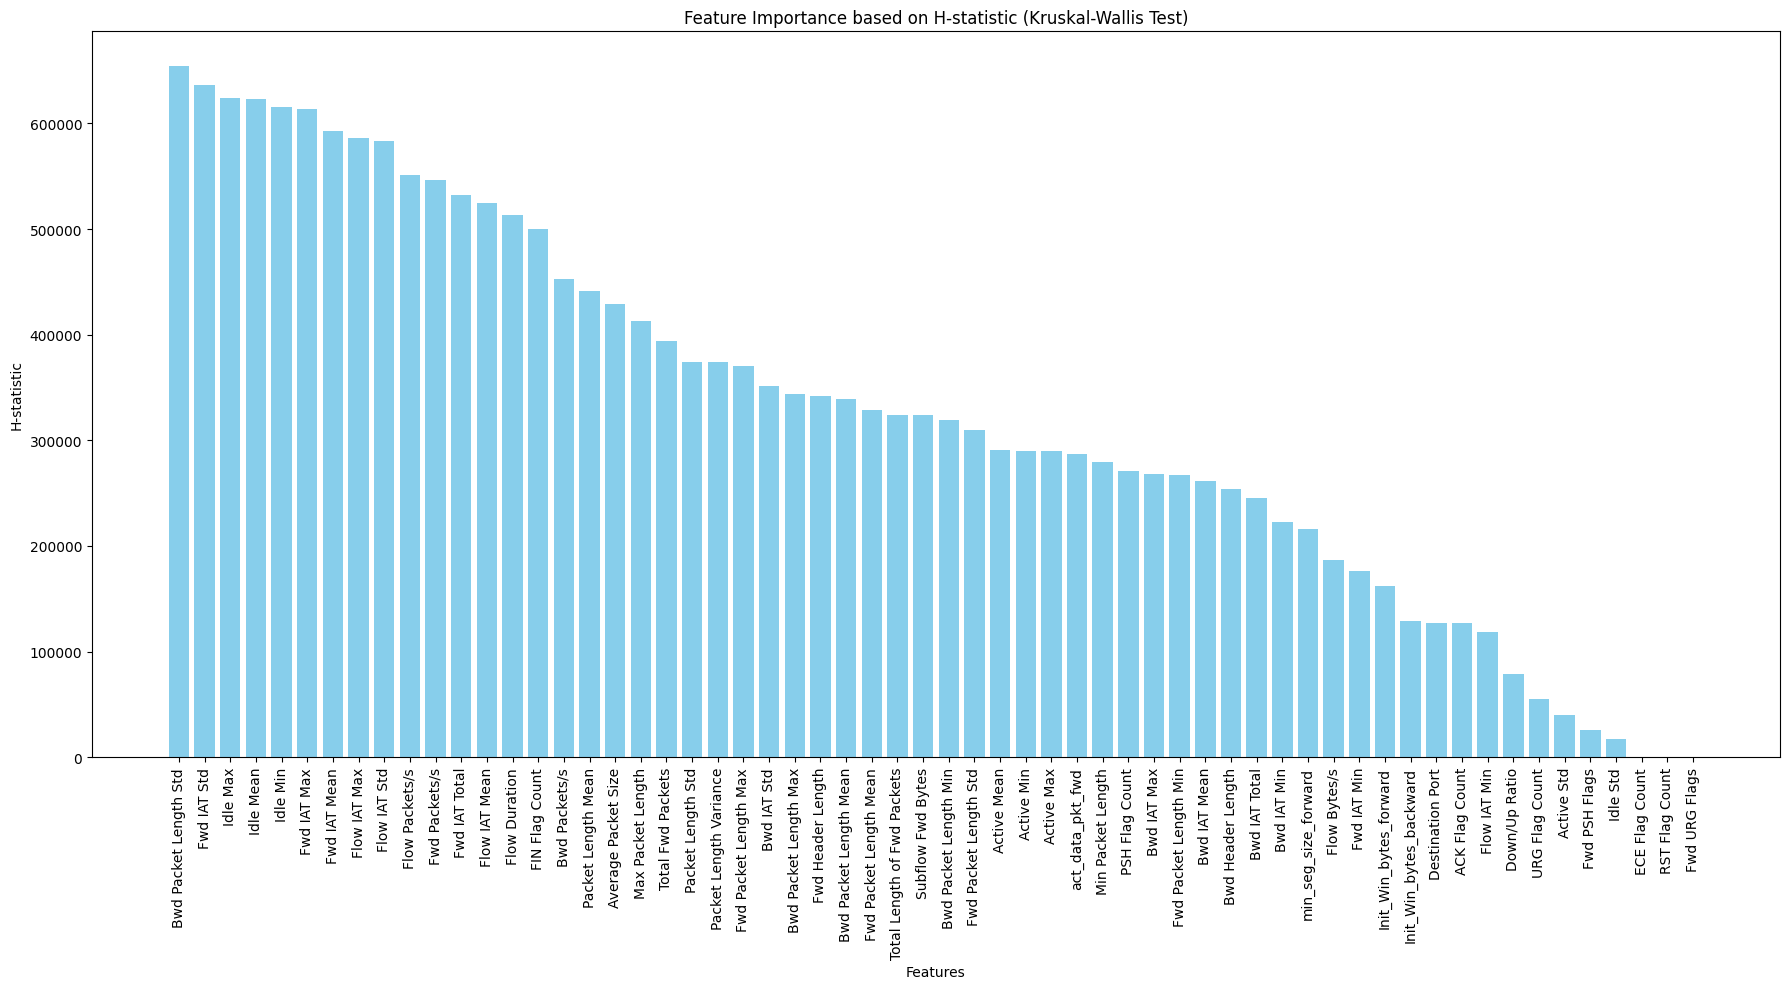

In [50]:
# Analysing feature importance using Kruskal-Wallis.
h_p_stats = analyze_feature_importance(data, numeric_features)

Now that we have the results from the Kruskal-Wallis test, we will train a Random Forest model and analyze its feature importance scores. This will provide an additional perspective on feature relevance, which we can then compare to the rankings obtained from the Kruskal-Wallis test.

Cross-Validation Score: 0.9986 ± 0.0001

Classification Report:

                precision    recall  f1-score   support

          Bots       0.86      0.74      0.79       584
   Brute Force       1.00      1.00      1.00      2745
          DDoS       1.00      1.00      1.00     38404
           DoS       1.00      1.00      1.00     58124
Normal Traffic       1.00      1.00      1.00    628518
 Port Scanning       0.99      0.99      0.99     27208
   Web Attacks       0.99      0.97      0.98       643

      accuracy                           1.00    756226
     macro avg       0.98      0.96      0.97    756226
  weighted avg       1.00      1.00      1.00    756226




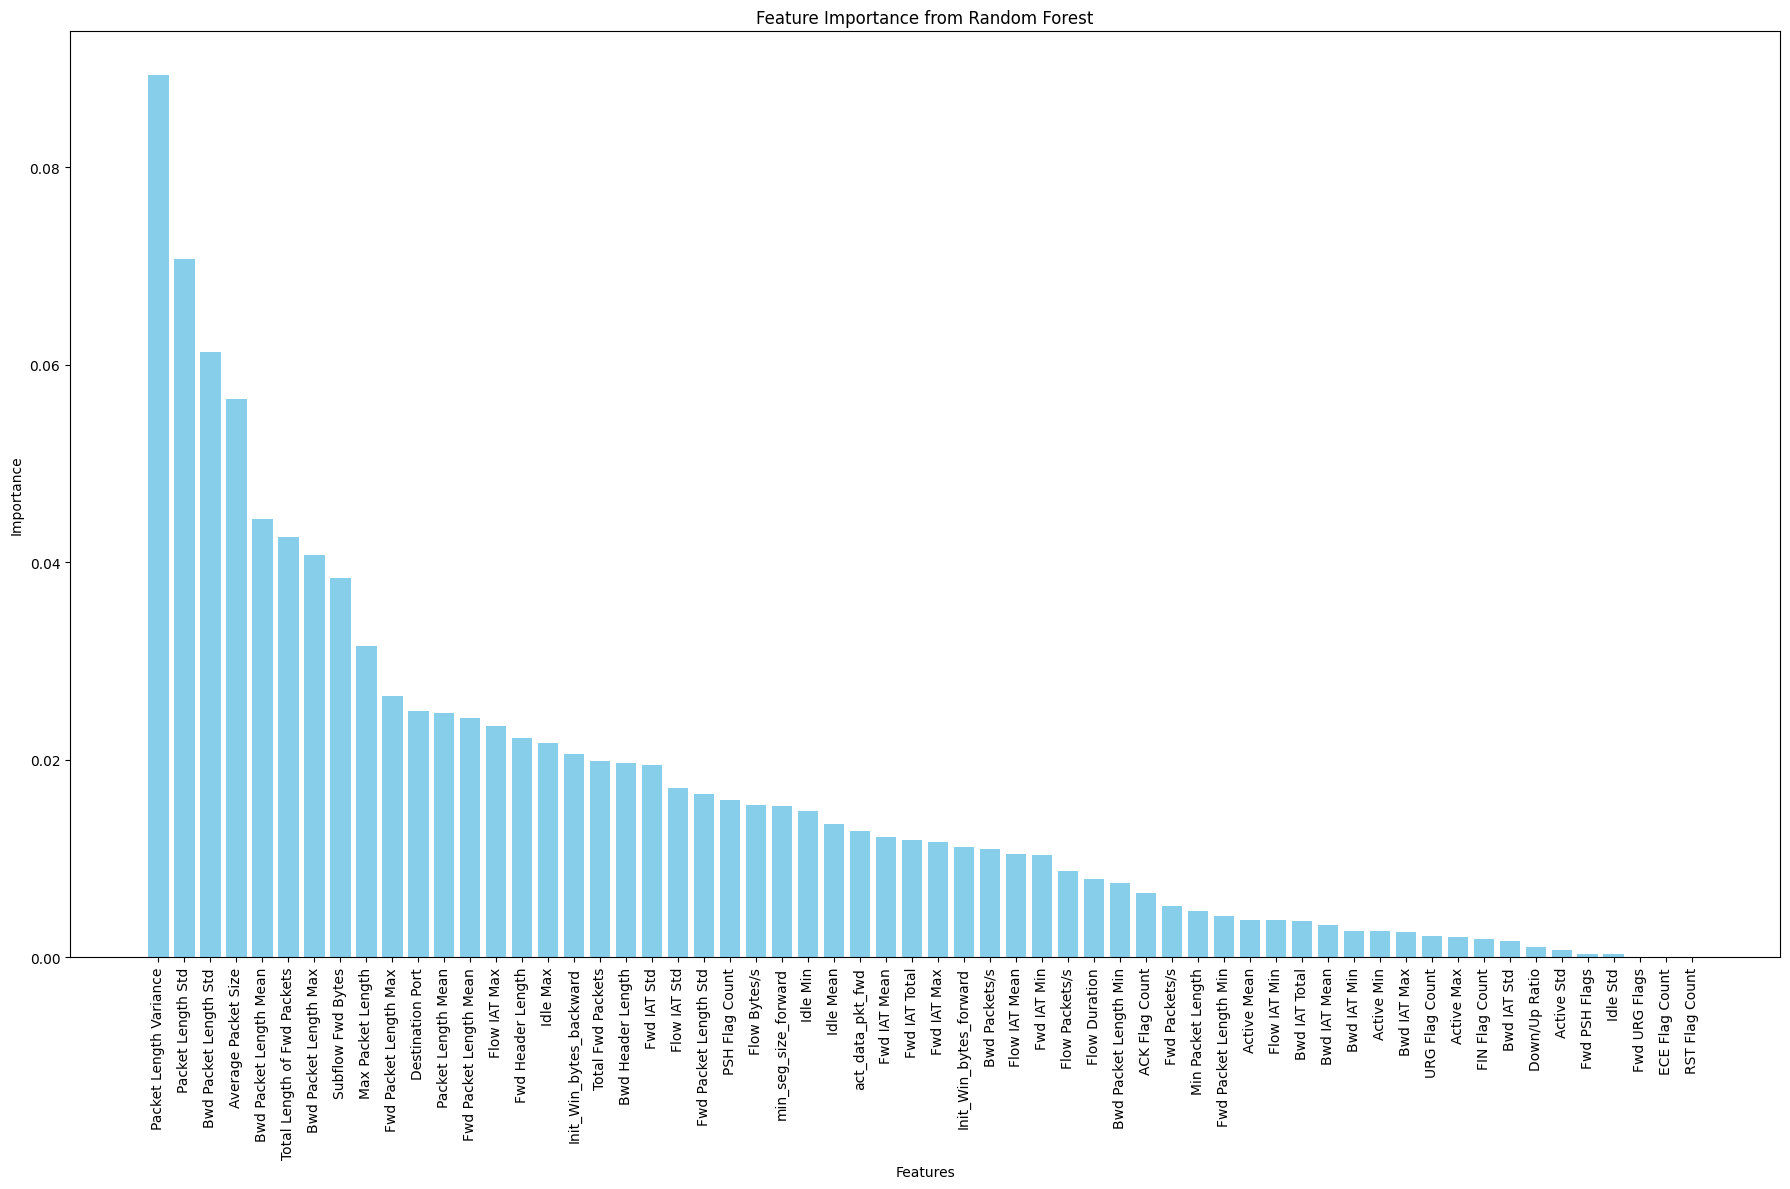

In [51]:
# Analysing feature importance using Tree-Model
feature_importance_tree, cm, rf_labels, cv_scores = analyze_feature_importance_rf(data, numeric_features)

Random Forests, being ensemble methods, offer a built-in mechanism for assessing feature importance. This importance is calculated based on how much each feature contributes to decreasing impurity (e.g., Gini impurity or entropy) within the decision trees of the forest. Features used higher up in the trees or in more trees of the forest for making splits are considered more important as they contribute more significantly to the model's predictive performance.

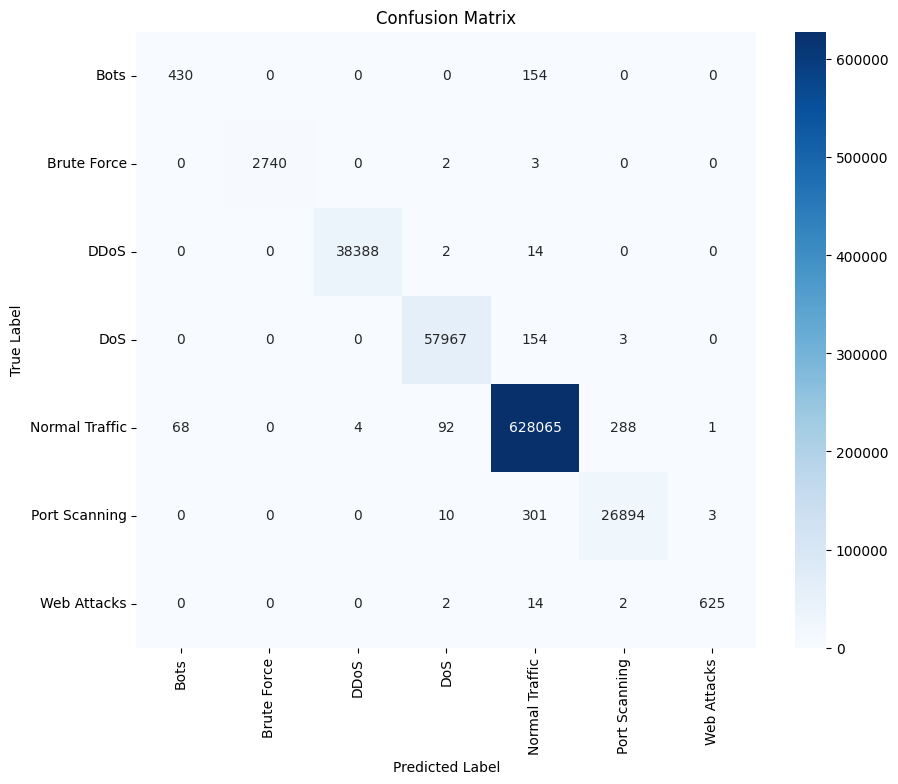

In [52]:
# Evaluating RF performance based on selected features
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8)) # Adjust figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=rf_labels, yticklabels=rf_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

After evaluating the Random Forest model's performance, we observe an overall positive result, indicating its suitability for feature importance analysis. However, the confusion matrix and the classification report reveal a notable weakness in classifying Bot attacks, with roughly 1/4 of these instances being misclassified as normal traffic (which is not surprising, considering this is a minority class). This misclassification highlights a potential area for improvement in our final intrusion detection model, which could be explored by considering more sophisticated bot detection methods, specialized feature engineering, and data balancing techniques. Despite this limitation, the overall performance justifies using the Random Forest's feature importance scores as a valuable reference for comparison with the Kruskal-Wallis H-statistic in our subsequent feature selection process.

In [53]:
# Preparing the df for comparison
h_p_stats.reset_index(inplace = True)
h_p_stats.rename(columns = {'index':'Feature'}, inplace = True)

# Sorting the new df for easier visualization
comparison_tb = feature_importance_tree.merge(h_p_stats, on = 'Feature', how = 'left')
comparison_tb_sorted = comparison_tb.sort_values(by='Importance', ascending=False)
comparison_tb_sorted

,Feature,Importance,H-statistic,p-value
0,Packet Length Variance,8.931445e-02,373845.434316,0.000000e+00
1,Packet Length Std,7.069681e-02,373896.560353,0.000000e+00
2,Bwd Packet Length Std,6.131436e-02,654400.346609,0.000000e+00
3,Average Packet Size,5.653880e-02,429097.080675,0.000000e+00
4,Bwd Packet Length Mean,4.442698e-02,338820.640791,0.000000e+00
5,Total Length of Fwd Packets,4.252596e-02,324367.440051,0.000000e+00
6,Bwd Packet Length Max,4.078398e-02,343538.176327,0.000000e+00
7,Subflow Fwd Bytes,3.836811e-02,324367.440051,0.000000e+00
8,Max Packet Length,3.153551e-02,413042.599252,0.000000e+00
9,Fwd Packet Length Max,2.642692e-02,370387.060527,0.000000e+00


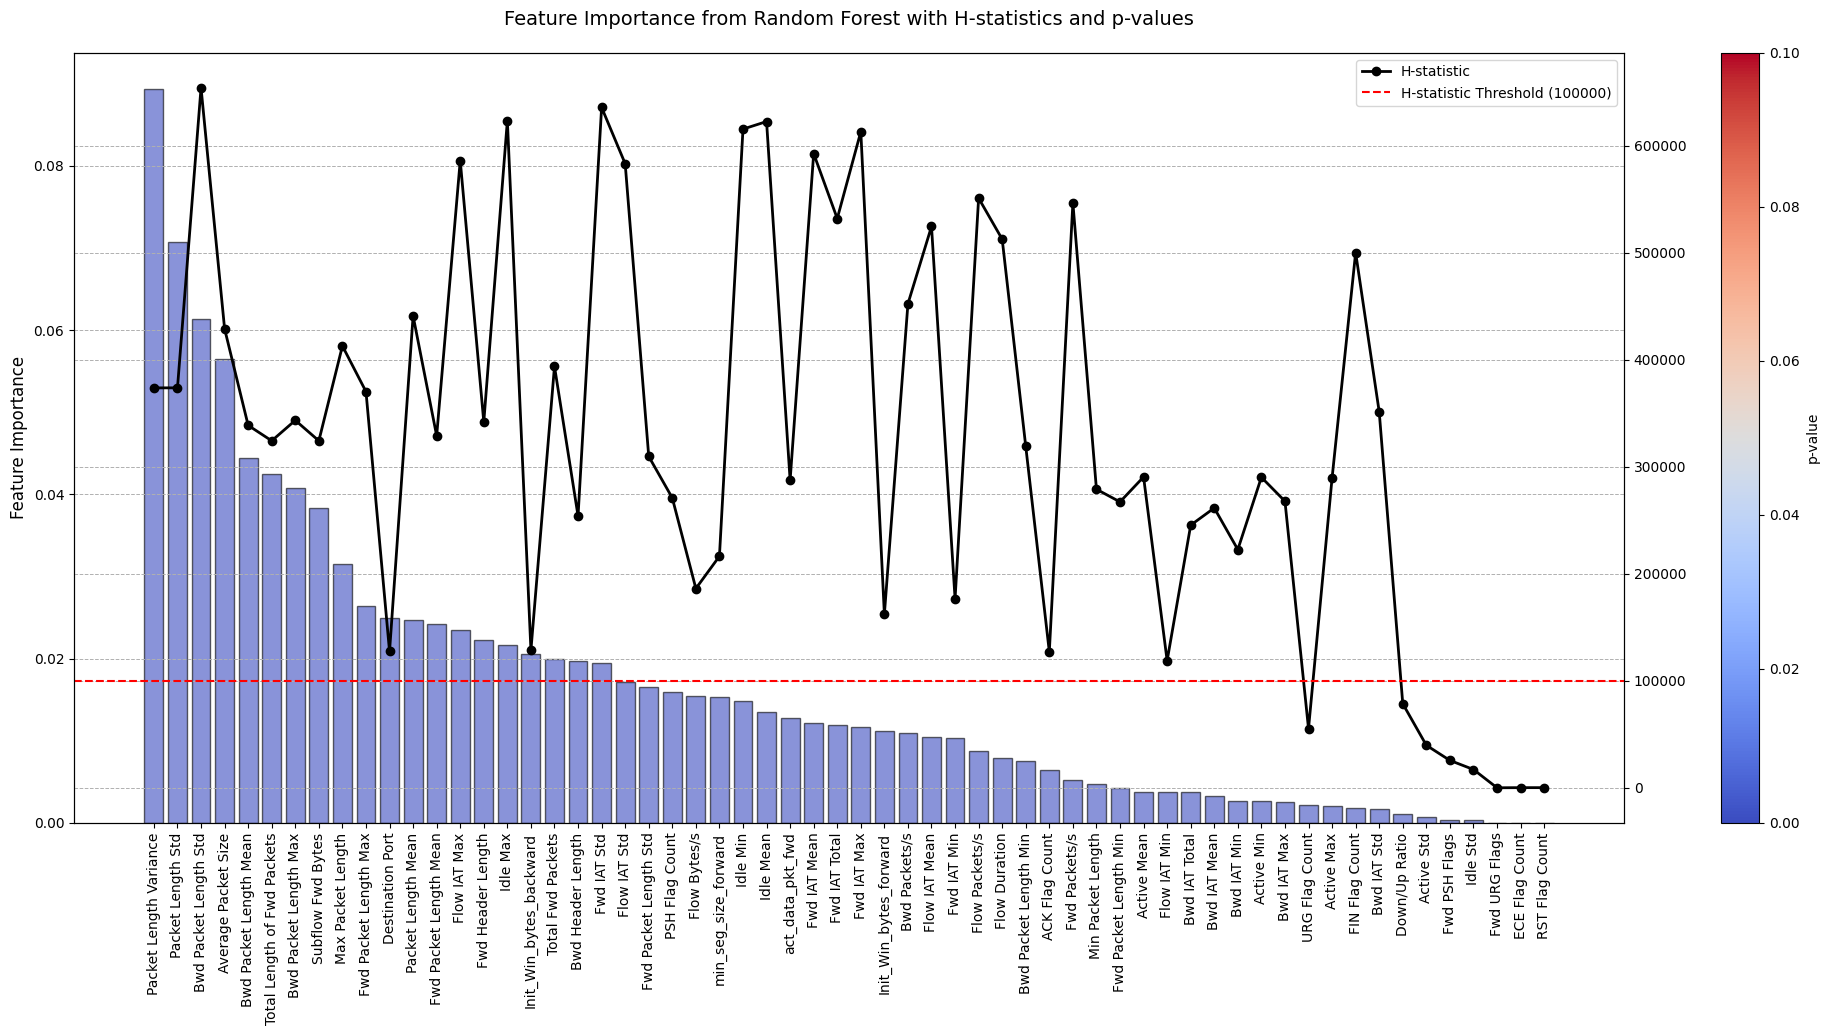

In [54]:
# Create figure and axis
plt.figure(figsize=(25, 10))

# Create a color map based on p-value
colors = sns.color_palette("coolwarm", as_cmap=True)

# Create twin axes for different scales
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot bars for importance
bars = ax1.bar(comparison_tb_sorted['Feature'],
                comparison_tb_sorted['Importance'],
                alpha=0.6,
                color=[colors(0 + (value)) for value in comparison_tb_sorted['p-value']], edgecolor='black')

# Plot line for H-statistic
line = ax2.plot(comparison_tb_sorted['Feature'],
                 comparison_tb_sorted['H-statistic'],
                 color='black',
                 linewidth=2,
                 label='H-statistic',
                 marker='o')

# Add a horizontal threshold line
threshold = 100000
ax2.axhline(y=threshold, color='red', linestyle='--', label=f'H-statistic Threshold ({threshold})')
ax2.legend()

# Customize primary y-axis (Importance)
ax1.set_ylabel('Feature Importance', fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Set x-ticks and labels
ax1.set_xticks(range(len(comparison_tb_sorted['Feature'])))
ax1.set_xticklabels(comparison_tb_sorted['Feature'], rotation=90, ha='center', fontsize=10)

# Add title
plt.title('Feature Importance from Random Forest with H-statistics and p-values',
          fontsize=14, pad=20)

# Add colorbar for p-values
sm = plt.cm.ScalarMappable(cmap=colors, norm=plt.Normalize(vmin=comparison_tb_sorted['p-value'].min(), vmax=0.1))
cbar = plt.colorbar(sm, ax=ax1, orientation='vertical')
cbar.set_label('p-value', fontsize=10)

# Add gridlines for readability
ax1.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)
ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

plt.show()


The plot illustrates that while some features selected by the Random Forest (RF) have lower H-statistics, the most significant features are found within the range where the highest H-statistic values are concentrated. The most interesting information, however, lies on the right tail, where there is a convergence on the lowest priority and near-zero H-statistic relevance. Based on these results, the least important features will be removed from the dataset, which helps with:

 * Improving Model Efficiency: Training with fewer features reduces computational cost (time and memory).
 * Reducing Noise: Removing irrelevant features can sometimes improve model performance by reducing noise and preventing overfitting.
 * Simplifying Interpretation: Models with fewer features are often easier to interpret and explain.

In [55]:
# Removing statiscally irrelavant features from the dataset
cols_to_remove = ['ECE Flag Count', 'RST Flag Count', 'Fwd URG Flags', 'Idle Std', 'Fwd PSH Flags', 'Active Std', 'Down/Up Ratio', 'URG Flag Count']
data.drop(columns=cols_to_remove, inplace=True)

## 5.1. Overview of the Final Columns

| **Column Name**                    | **Description**                                                                                                                                             |
|-------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Destination Port                    | The destination port for the flow.                                                                                                                         |
| Flow Duration                       | The duration of the flow.                                                                                                                                   |
| Total Fwd Packets                   | The total number of forwarded packets in the flow.                                                                                                         |
| Total Length of Fwd Packets         | The total length of forwarded packets in the flow.                                                                                                         |
| Fwd Packet Length Max               | The maximum size of forwarded packets.                                                                                                                      |
| Fwd Packet Length Min               | The minimum size of forwarded packets.                                                                                                                     |
| Fwd Packet Length Mean              | The average length of forwarded packets in the flow.                                                                                                       |
| Fwd Packet Length Std               | The standard deviation of forwarded packet lengths in the flow.                                                                                           |
| Bwd Packet Length Max               | The maximum size of backward packets.                                                                                                                       |
| Bwd Packet Length Min               | The minimum size of backward packets.                                                                                                                     |
| Bwd Packet Length Mean              | The average size of backward packets.                                                                                                                       |
| Bwd Packet Length Std               | The standard deviation of backward packet lengths in the flow.                                                                                             |
| Flow Bytes/s                        | The number of bytes transferred per second in the flow.                                                                                                   |
| Flow Packets/s                      | The number of packets transferred per second in the flow.                                                                                                  |
| Flow IAT Mean                       | The average inter-arrival time of packets in the flow.                                                                                                     |
| Flow IAT Std                        | The standard deviation of the inter-arrival times of packets in the flow.                                                                                  |
| Flow IAT Max                        | The maximum inter-arrival time of packets in the flow.                                                                                                      |
| Flow IAT Min                        | The minimum inter-arrival time of packets in the flow.                                                                                                     |
| Fwd IAT Total                       | The total forward inter-arrival time observed during the flow.                                                                                             |
| Fwd IAT Mean                        | The mean forward inter-arrival time observed during the flow.                                                                                              |
| Fwd IAT Std                         | The standard deviation of the forward inter-arrival time during the flow.                                                                                 |
| Fwd IAT Max                         | The maximum forward inter-arrival time observed during the flow.                                                                                           |
| Fwd IAT Min                         | The minimum forward inter-arrival time observed during the flow.                                                                                           |
| Bwd IAT Total                       | The total backward inter-arrival time during the flow.                                                                                                    |
| Bwd IAT Mean                        | The average backward inter-arrival time during the flow.                                                                                                  |
| Bwd IAT Std                         | The standard deviation of the backward inter-arrival time during the flow.                                                                                 |
| Bwd IAT Max                         | The maximum backward inter-arrival time during the flow.                                                                                                  |
| Bwd IAT Min                         | The minimum backward inter-arrival time during the flow.                                                                                                  |
| Fwd Header Length                   | The total length of the header in forwarded packets.                                                                                                       |
| Bwd Header Length                   | The total length of the header in backward packets.                                                                                                        |
| Fwd Packets/s                       | The number of forwarded packets transferred per second in the flow.                                                                                        |
| Bwd Packets/s                       | The number of backward packets transferred per second in the flow.                                                                                        |
| Min Packet Length                   | The minimum packet length observed in the flow.                                                                                                            |
| Max Packet Length                   | The maximum packet length observed in the flow.                                                                                                            |
| Packet Length Mean                  | The average packet length in the flow.                                                                                                                     |
| Packet Length Std                   | The standard deviation of packet lengths in the flow.                                                                                                      |
| Packet Length Variance              | The variance of packet lengths in the flow.                                                                                                                |
| FIN Flag Count                      | The number of FIN flags observed in the flow.                                                                                                               |
| PSH Flag Count                      | The number of PSH flags observed in the flow.                                                                                                               |
| ACK Flag Count                      | The number of ACK flags observed in the flow.                                                                                                               |
| Average Packet Size                 | The average size of the packets in the flow.                                                                                                               |
| Subflow Fwd Bytes                   | The number of bytes in the forwarded subflow.                                                                                                              |
| Init_Win_bytes_forward              | The initial window size in bytes in the forward direction.                                                                                                 |
| Init_Win_bytes_backward             | The initial window size in bytes in the backward direction.                                                                                                |
| act_data_pkt_fwd                    | The number of active data packets forwarded.                                                                                                               |
| min_seg_size_forward                | The minimum segment size forwarded in the flow.                                                                                                            |
| Active Mean                         | The average amount of activity observed during the flow.                                                                                                   |
| Active Max                          | The maximum amount of activity observed during the flow.                                                                                                   |
| Active Min                          | The minimum amount of activity observed during the flow.                                                                                                   |
| Idle Mean                           | The average idle time observed during the flow.                                                                                                            |
| Idle Max                            | The maximum idle time observed during the flow.                                                                                                            |
| Idle Min                            | The minimum idle time observed during the flow.                                                                                                            |
| Attack Type                         | The target class, indicating the type of attack or normal traffic.                                                                                        |


# 6. Outputs

**Note on Sampling and Scaling Techniques:**
Applying resampling and/or scaling techniques, such as SMOTE and RobustScaler, to the entire dataset would violate the principle of keeping the test set unseen during model training. This could lead to overly optimistic performance metrics, as the model might indirectly gain information about the test set during training. Based on the analysis performed on this notebook, both techniques can benefit when fitting models. However, these methods will only be implemented on the [next notebook](https://www.kaggle.com/code/ericanacletoribeiro/cicids2017-machine-learning-models-comparison), when the dataset will be splitted into training and test sets, focusing on training and comparing machine learning models.

In [56]:
# Clean dataset to a CSV file
data.to_csv('cicids2017_cleaned.csv', index=False)

This dataset has been made available on Kaggle [here](https://www.kaggle.com/datasets/ericanacletoribeiro/cicids2017-cleaned-and-preprocessed).

The complete pipeline is [available on Github](https://github.com/anacletu/ml-intrusion-detection-cicids2017).